# Project 1

# My code

# Part A

This is how we generate the data. The value of J in this case is fixed to 1.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.linalg as scl
from sklearn.model_selection import train_test_split
import tqdm

sns.set(color_codes=True)
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

L = 50
n = int(1e4)

spins = np.random.choice([-1, 1], size=(n, L))
J = 1.0

energies = np.zeros(n)

for i in range(n):
    energies[i] = - J * np.dot(spins[i], np.roll(spins[i], 1))

Now we will try to split the data in training and test data

In [33]:
X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)

X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

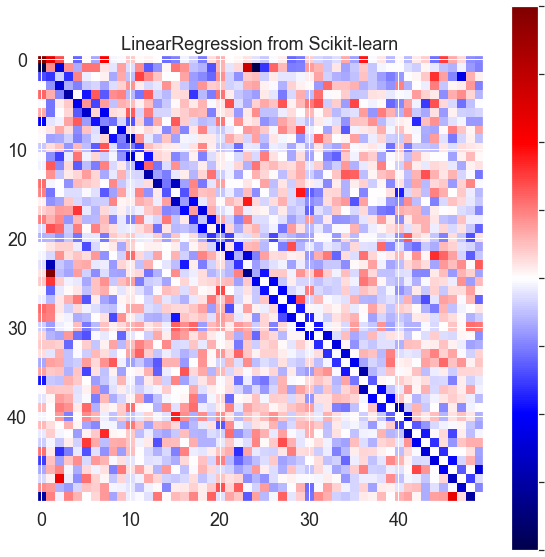

In [61]:
import sklearn.linear_model as skl
clf = skl.LinearRegression().fit(X_train, y_train)
J_sk = clf.coef_.reshape(L, L)
fig = plt.figure(figsize=(10, 10))
im = plt.imshow(J_sk, **cmap_args)
plt.title("LinearRegression from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

# Part B

The Ridge regresion method 

100%|██████████| 10/10 [02:52<00:00, 17.23s/it]


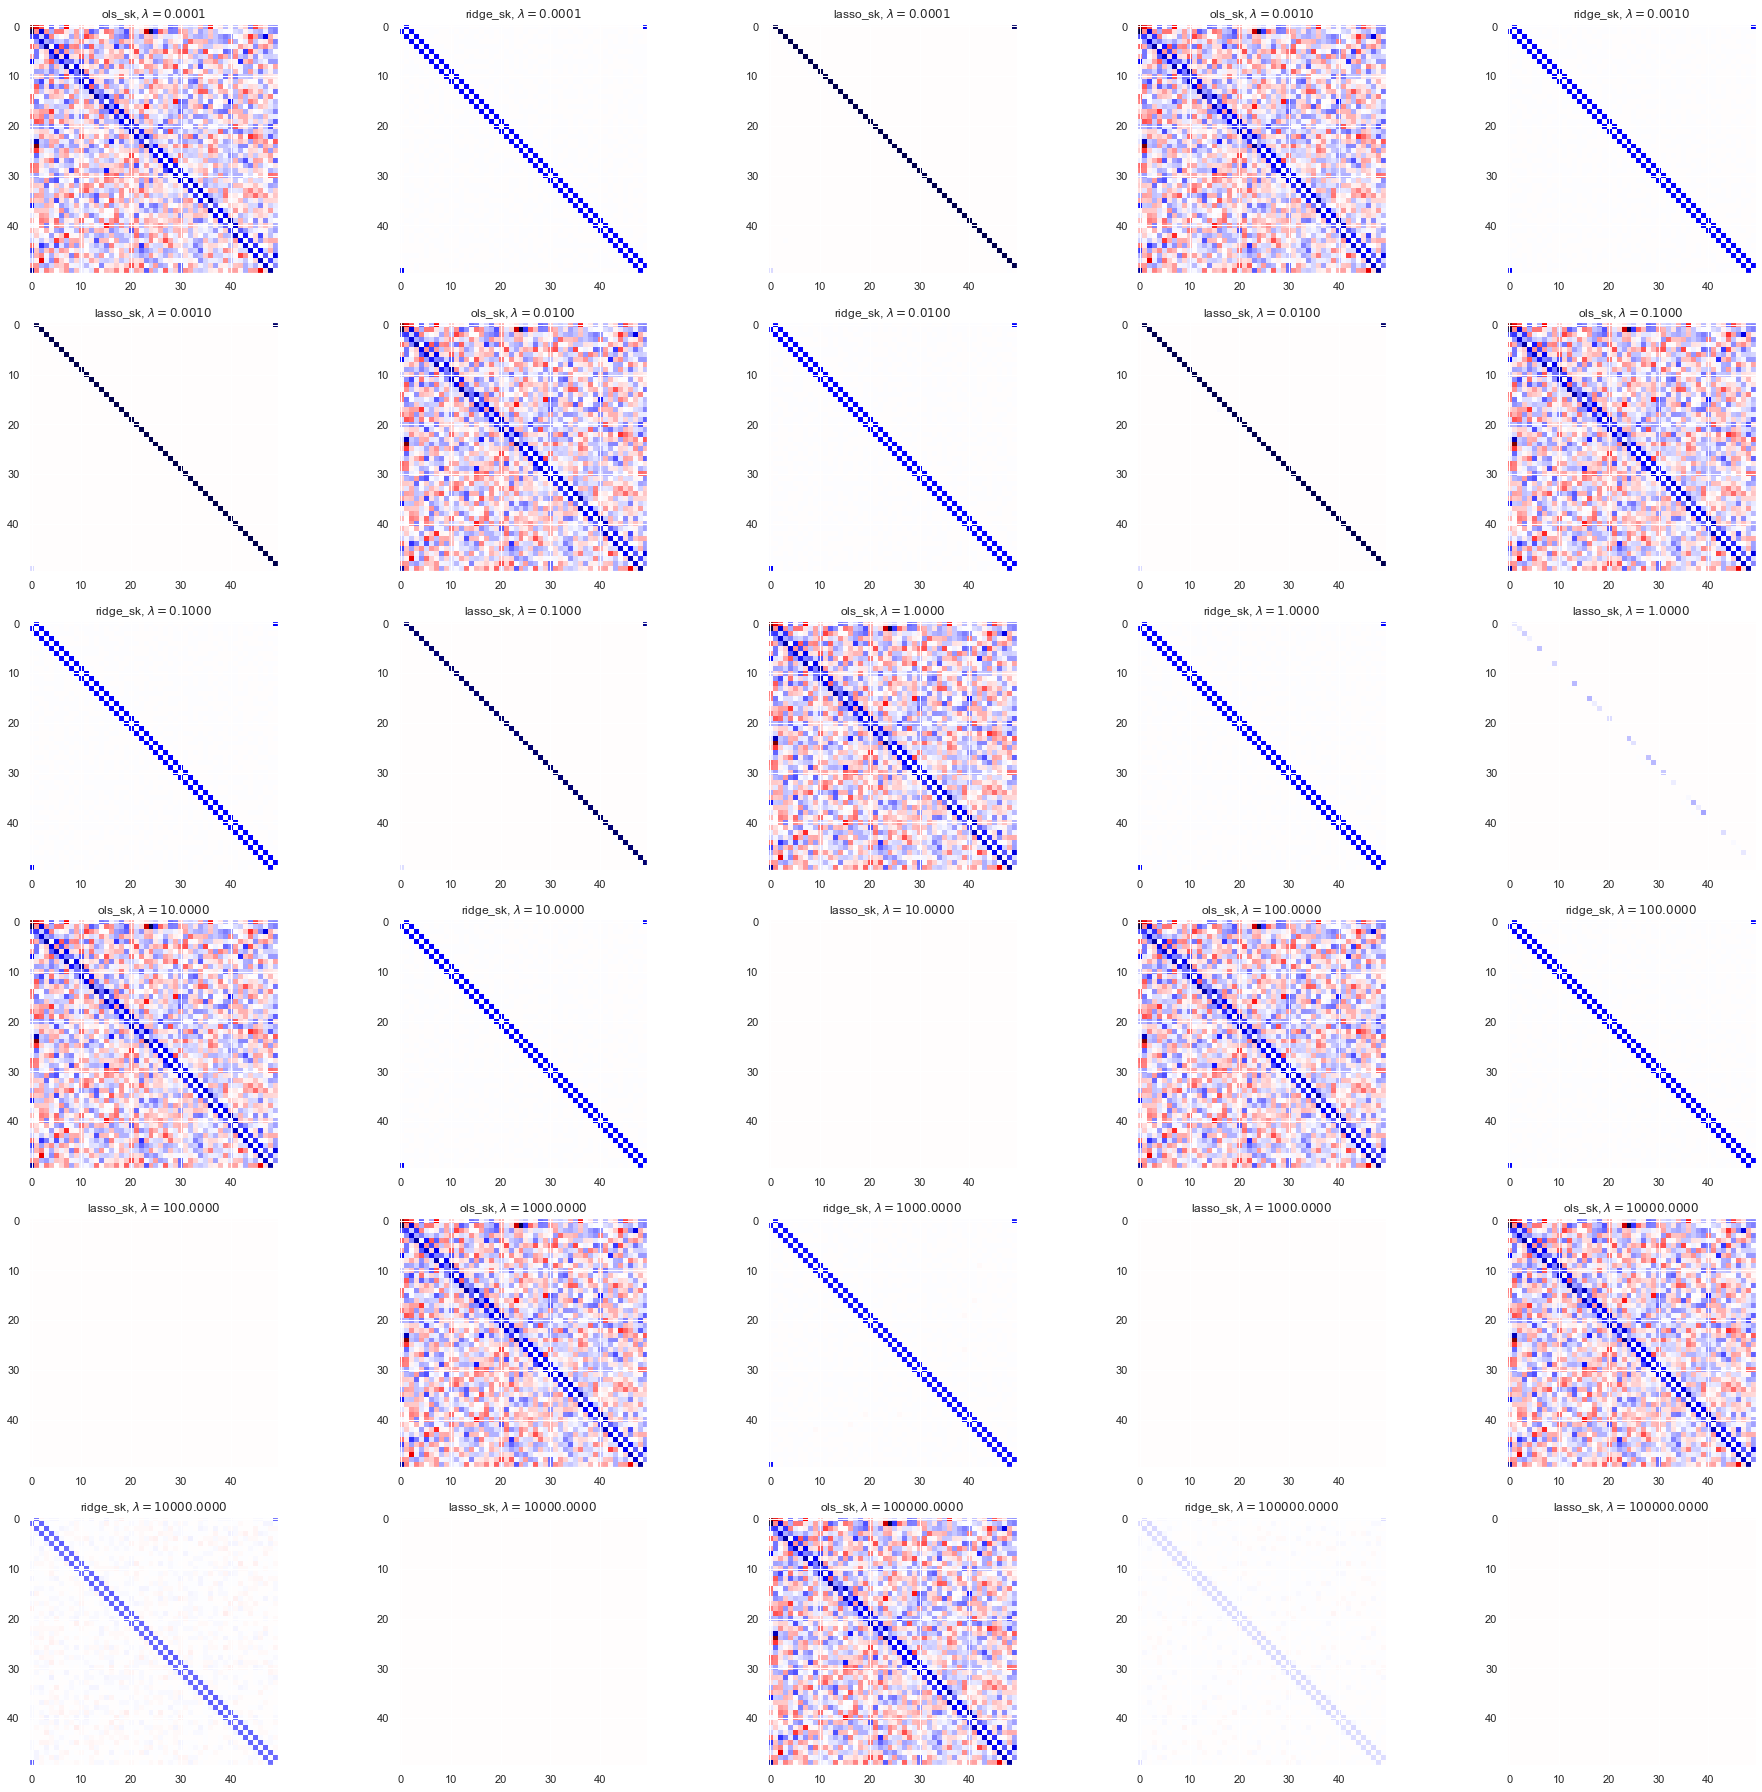

In [60]:
lambdas = np.logspace(-4, 5, 10)

train_errors = {
    "ols_sk": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

#test_errors = {
 #   "ols_sk": np.zeros(lambdas.size),
  #  "ridge_sk": np.zeros(lambdas.size),
   # "lasso_sk": np.zeros(lambdas.size)
#}

plot_counter = 1

fig = plt.figure(figsize=(32, 54))

for i, _lambda in enumerate(tqdm.tqdm(lambdas)):
    for key, method in zip(
        ["ols_sk", "ridge_sk", "lasso_sk"],
        [skl.LinearRegression(), skl.Ridge(alpha=_lambda), skl.Lasso(alpha=_lambda)]
    ):
        method = method.fit(X_train, y_train)

        train_errors[key][i] = method.score(X_train, y_train)
        #test_errors[key][i] = method.score(X_test, y_test)

        omega = method.coef_.reshape(L, L)

        plt.subplot(10, 5, plot_counter)
        plt.imshow(omega, **cmap_args)
        plt.title(r"%s, $\lambda = %.4f$" % (key, _lambda))
        plot_counter += 1

plt.show()

# Code from Mehta et al

In [62]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model aprams
# system size
L=40  # the number of spins in a string

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    L = states.shape[1]
    J = np.zeros((L, L),)
    for i in range(L): 
        J[i,(i+1)%L]=-1.0 # interaction between nearest-neighbors
        
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states)

In [63]:
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[states,energies]

In [64]:
# define number of samples
n_samples=400
# define train and test data sets
X_train=Data[0][:n_samples]
Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples//2]
Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

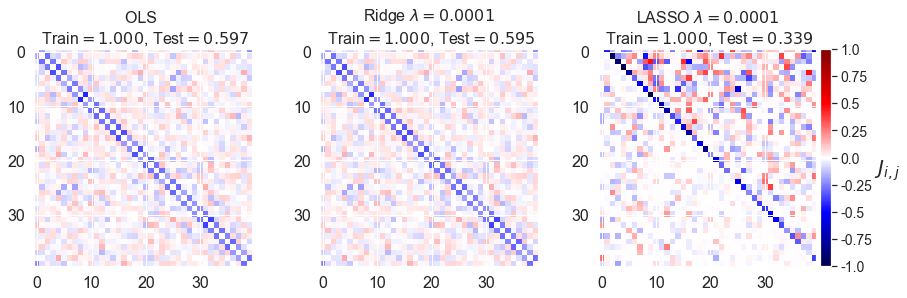

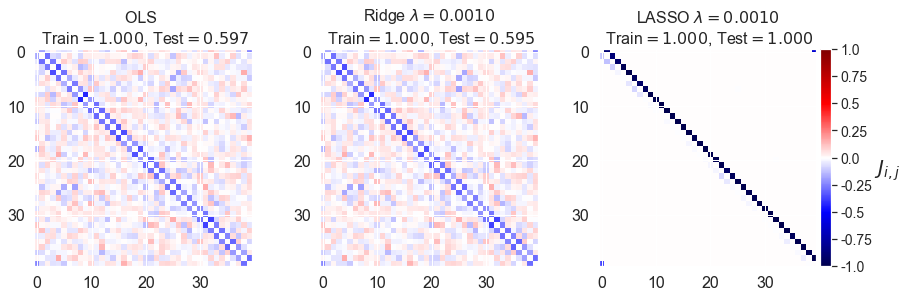

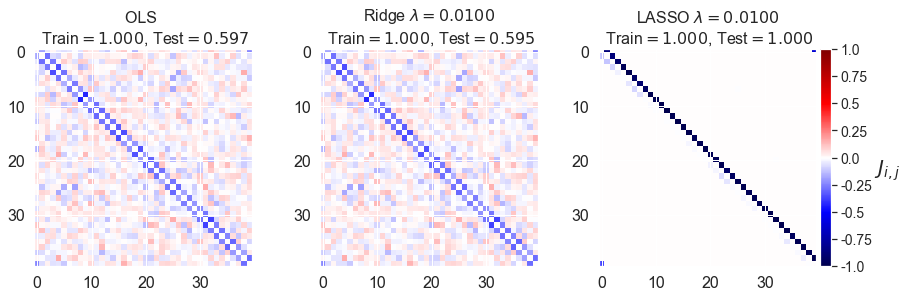

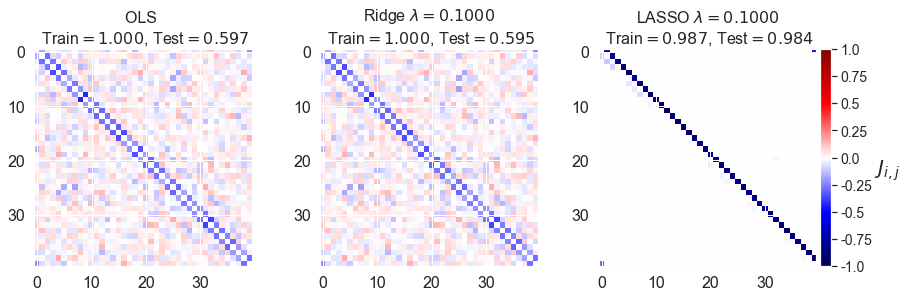

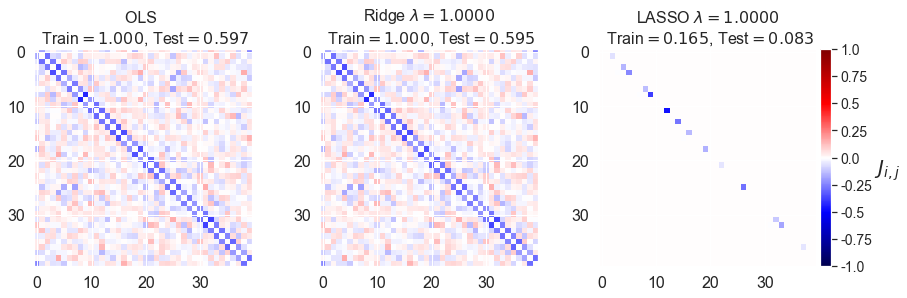

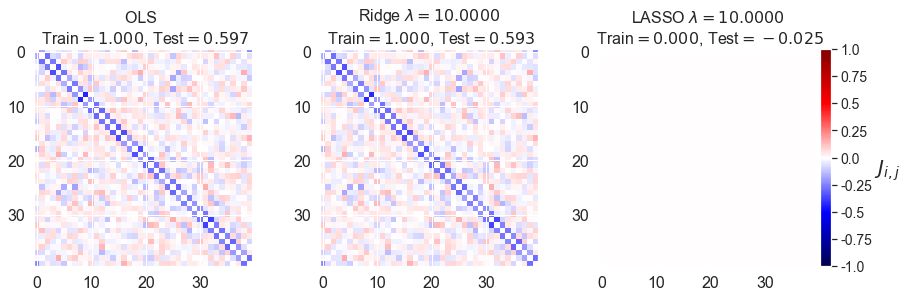

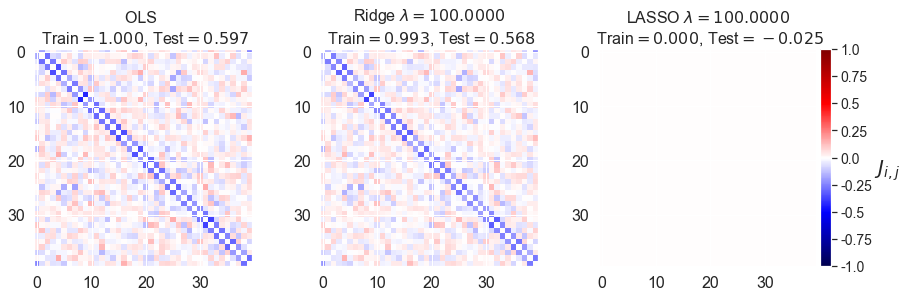

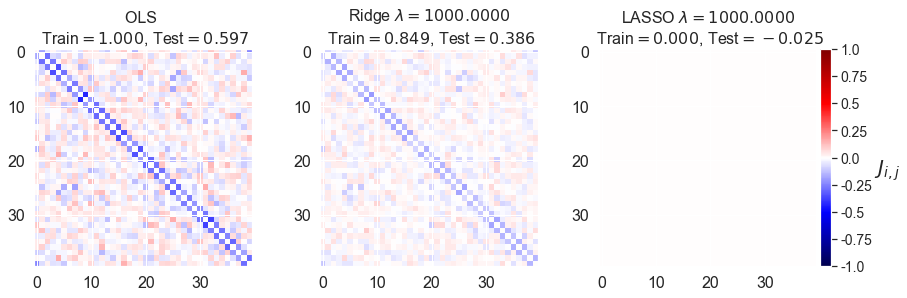

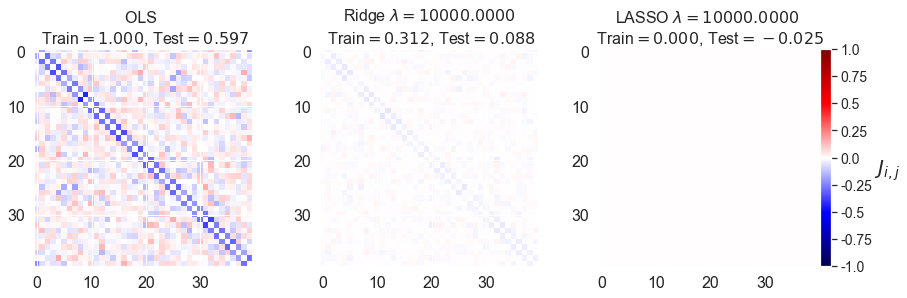

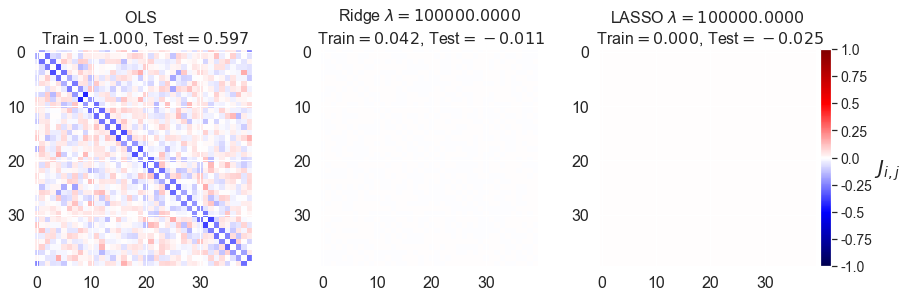

In [65]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
leastsq=linear_model.LinearRegression()
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []

train_errors_ridge = []
test_errors_ridge = []

train_errors_lasso = []
test_errors_lasso = []

# set regularisation strength values
lmbdas = np.logspace(-4, 5, 10)

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

for lmbda in lmbdas:
    
    ### ordinary least squares
    leastsq.fit(X_train, Y_train) # fit model 
    coefs_leastsq.append(leastsq.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_leastsq.append(leastsq.score(X_train, Y_train))
    test_errors_leastsq.append(leastsq.score(X_test,Y_test))
    
    ### apply RIDGE regression
    ridge.set_params(alpha=lmbda) # set regularisation parameter
    ridge.fit(X_train, Y_train) # fit model 
    coefs_ridge.append(ridge.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, Y_train))
    test_errors_ridge.append(ridge.score(X_test,Y_test))
    
    ### apply LASSO regression
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))

    ### plot Ising interaction J
    J_leastsq=np.array(leastsq.coef_).reshape((L,L))
    J_ridge=np.array(ridge.coef_).reshape((L,L))
    J_lasso=np.array(lasso.coef_).reshape((L,L))

    cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,**cmap_args)
    axarr[0].set_title('OLS \n Train$=%.3f$, Test$=%.3f$'%(train_errors_leastsq[-1], test_errors_leastsq[-1]),fontsize=16)
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge,**cmap_args)
    axarr[1].set_title('Ridge $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lmbda,train_errors_ridge[-1],test_errors_ridge[-1]),fontsize=16)
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso,**cmap_args)
    axarr[2].set_title('LASSO $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lmbda,train_errors_lasso[-1],test_errors_lasso[-1]),fontsize=16)
    axarr[2].tick_params(labelsize=16)
    
    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    cbar=fig.colorbar(im, cax=cax)
    
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=15, y=0.5,fontsize=20,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

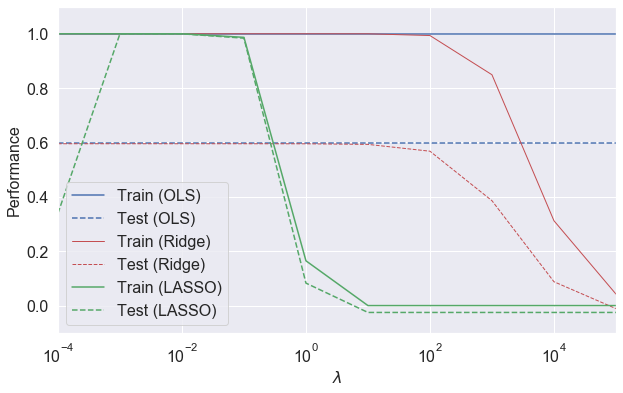

In [66]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_errors_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_errors_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_errors_ridge,'r',label='Train (Ridge)',linewidth=1)
plt.semilogx(lmbdas, test_errors_ridge,'--r',label='Test (Ridge)',linewidth=1)
plt.semilogx(lmbdas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_errors_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left',fontsize=16)
plt.ylim([-0.1, 1.1])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('Performance',fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

# PART C

In [67]:
import numpy as np

import warnings
#Comment this to turn on warnings
#warnings.filterwarnings('ignore')

np.random.seed() # shuffle random seed generator

# Ising model parameters
L=40 # linear system size
J=-1.0 # Ising interaction
T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

In [85]:
import pickle, os
from urllib.request import urlopen 

# url to data
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

######### LOAD DATA
# The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
# The labels are obtained from the following file:
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"


#DATA
data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

#LABELS (convention is 1 for ordered states and 0 for disordered states)
labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

In [90]:
print(np.shape(data))

(160000, 1600)


In [82]:
from sklearn.model_selection import train_test_split

###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

# full data set
X=np.concatenate((X_critical,X))
Y=np.concatenate((Y_critical,Y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

X_train shape: (65000, 1600)
Y_train shape: (65000,)

65000 train samples
30000 critical samples
65000 test samples


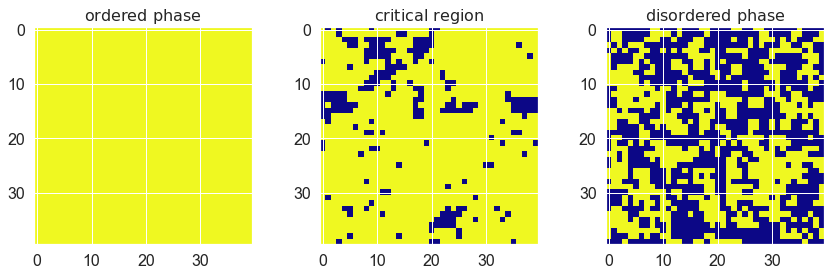

In [70]:
##### plot a few Ising states
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L,L),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[10001].reshape(L,L),**cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[50001].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

accuracy: train, test, critical
liblin: 0.7288, 0.6868, 0.6221
SGD: 0.4817, 0.4701, 0.5219
finished computing 1/11 iterations
accuracy: train, test, critical
liblin: 0.7288, 0.6868, 0.6221
SGD: 0.7221, 0.6997, 0.5522
finished computing 2/11 iterations
accuracy: train, test, critical
liblin: 0.7288, 0.6868, 0.6221
SGD: 0.5470, 0.5074, 0.5775
finished computing 3/11 iterations
accuracy: train, test, critical
liblin: 0.7288, 0.6868, 0.6221
SGD: 0.7012, 0.6598, 0.6020
finished computing 4/11 iterations
accuracy: train, test, critical
liblin: 0.7288, 0.6868, 0.6221
SGD: 0.6754, 0.6415, 0.6795
finished computing 5/11 iterations
accuracy: train, test, critical
liblin: 0.7288, 0.6868, 0.6221
SGD: 0.5642, 0.5524, 0.6774
finished computing 6/11 iterations
accuracy: train, test, critical
liblin: 0.7287, 0.6867, 0.6224
SGD: 0.4591, 0.4640, 0.3333
finished computing 7/11 iterations
accuracy: train, test, critical
liblin: 0.7282, 0.6861, 0.6240
SGD: 0.4591, 0.4640, 0.3333
finished computing 8/11 ite

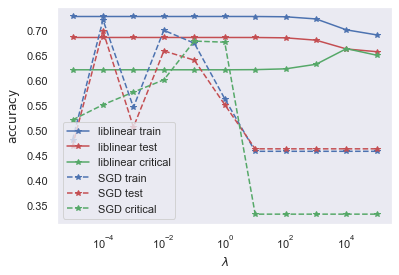

In [76]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

# Part D